In [237]:
%reset -f
import matplotlib.pyplot as plt
import numpy as np
import corner
import sncosmo
from scipy.interpolate import interp1d as interp1d
import sys
import time
import pickle
import os

In [238]:
clrs=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

In [239]:
paper_out_dir='./out_dir/'

In [240]:
#stored ascii files
catalog_dir='./catalog_data/'
all_good_downsampled_data=np.loadtxt(catalog_dir+'down_sampled_data/'+'All_good_downsample.txt')
print(all_good_downsampled_data.shape)
idx2=np.where(all_good_downsampled_data[:,1]==2)[0]
idx4=np.where(all_good_downsampled_data[:,1]==4)[0]
print(len(idx2/2),len(idx4/4))

only_sysn_ni_data=np.loadtxt(catalog_dir+'down_sampled_data/'+'all_good_sys.txt')
print(len(only_sysn_ni_data[:,0]))
sysn_list_double=(only_sysn_ni_data[:,0])[only_sysn_ni_data[:,1]==2.]
sysn_list_quad=(only_sysn_ni_data[:,0])[only_sysn_ni_data[:,1]==4.]
print(len(sysn_list_double),len(sysn_list_quad))

(250, 16)
98 152
87
49 38


In [241]:
m_ref=0;F_ref=1.0e12
def get_flux(m):
    return F_ref*10**(0.4*(m_ref-m))

def get_mag(F):
    return m_ref-2.5*np.log10(F/F_ref)

def get_flu_err(m,sig_m):
    delF_delm=-0.4*np.log(10.)*F_ref*10**(0.4*(m_ref-m))
    sigF=np.abs(delF_delm)*sig_m
    
    return sigF

def get_flu_err2(m,sig_m):
    del_F=get_mag(m+sig_m)-get_mag(m-sig_m)
    
    return np.abs(del_F)/2.0

def calculate_length(obj):
    try:
        return len(obj)
    except TypeError:
        return 1
def get_interp(x,y):
    method='cubic'
    return interp1d(x,y, kind=method,bounds_error=False,fill_value=(y[0],y[-1]))

def get_shifted(y_interp,x,dx=0.0,mux=1.0):
    return mux*y_interp(x-dx)

def convert_np_arr(datalist):
    ii=0
    ret=[]
    for data in datalist:
        ret.append(np.array(data))
    return ret


In [242]:
infile=catalog_dir+'Om10_10y_LSNeIA_catalog.txt'

In [243]:
params = {'legend.fontsize': 10,
          'axes.labelsize': 16,
          'axes.titlesize': 13,
          #'xtick.labelsize' :11,
          #'ytick.labelsize': 11,
          'mathtext.fontset': 'cm',
          'mathtext.rm': 'serif',
          'grid.color': 'k',
          'grid.linestyle': ':',
          'grid.linewidth': 0.5,
          'savefig.bbox':'tight'
          #'axes.linewidth':tw
         }
plt.rcParams.update(params)
plt.rcParams["figure.figsize"] = (6.,4.0)

In [244]:
def min_max(A):
    return A.min(),A.max()


In [245]:
data_cols=np.loadtxt(infile)
print(data_cols.shape)

(124695, 16)


In [246]:
#columns are as follows
#sysn, s_mag_I,mag_deviation,s_z,lens_z,x_pos,y_pos,kappa,gamma,td,magnification,im_mag_I,im_sep
[sysn, s_mag_I,mag_deviation,s_z,lens_z,x_pos,y_pos,kappa,gamma,td,magnification,im_mag_I,im_sep,NIs,lens_vel_disp,lens_ellipticity]=[data_cols[:,ii] for ii in range(16)]

idx_dq=np.where(NIs!=3)[0]
[sysn, s_mag_I,mag_deviation,s_z,lens_z,x_pos,y_pos,kappa,gamma,td,magnification,im_mag_I,im_sep,NIs,lens_vel_disp,lens_ellipticity]=[data_cols[idx_dq,ii] for ii in range(16)]
sysn=sysn.astype(int)
print(NIs.shape,sysn.shape)

(124416,) (124416,)


In [247]:
(sysn[NIs==4][::4])[:20]

array([ 22,  24,  30,  36,  71,  75, 105, 137, 141, 145, 215, 245, 250,
       273, 320, 324, 377, 404, 417, 429])

In [248]:
def get_numbers_doubles_quads(sysn):
    #unique systems
    unique_sysn,bb,cc=np.unique(sysn,return_index=True, return_counts=True)
    Tot_Nsys_unique=len(unique_sysn)
    Nsys_unique_double=len(np.where(cc==2)[0])
    Nsys_unique_quad=len(np.where(cc==4)[0])
    if Nsys_unique_double+Nsys_unique_quad!=Tot_Nsys_unique:
        print("Problem, N_tot!=N_double + N_quad: Bad results")
    return [Tot_Nsys_unique, Nsys_unique_double, Nsys_unique_quad],[unique_sysn,bb,cc]
    
    


[Tot_Nsys_unique, Nsys_unique_double, Nsys_unique_quad],[Unique_sysn,Unique_sys_ids,Unique_im_counts]=get_numbers_doubles_quads(sysn)
print('total unique system=',Tot_Nsys_unique)
print('No. of doubles=',Nsys_unique_double, ' :: No. of quads=',Nsys_unique_quad)
print('No. of doubles + quads=',Nsys_unique_double+Nsys_unique_quad,' :: should match with ', Tot_Nsys_unique)

LSST_Imag_cut=22.6; LSST_im_sep_cut=0.5

print("----- With LSST-cut at %s mag and image sep more than %s -----"%(LSST_Imag_cut,LSST_im_sep_cut))
idx_cut=np.where((im_mag_I<=22.6) & (im_sep>0.5))[0]
sysn_check=sysn[idx_cut]
[totN,dubN,quadN],temp_info=get_numbers_doubles_quads(sysn_check)
print('Total, doubles, quads=',totN,dubN,quadN)
print('quad percentage=',quadN/totN)

total unique system= 56776
No. of doubles= 51344  :: No. of quads= 5432
No. of doubles + quads= 56776  :: should match with  56776
----- With LSST-cut at 22.6 mag and image sep more than 0.5 -----
Total, doubles, quads= 270 189 81
quad percentage= 0.3


Constarints: nothing on image separation; iband mag < 30.0


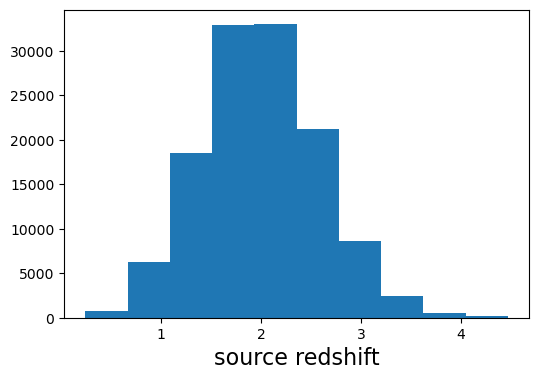

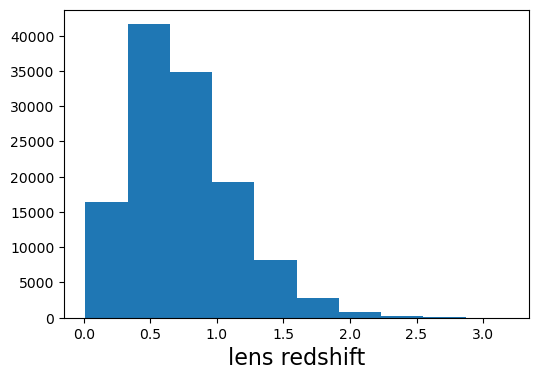

In [249]:
print("Constarints: nothing on image separation; iband mag < 30.0")
plt.hist(s_z)
plt.xlabel(r"source redshift")
plt.show()

plt.hist(lens_z)
plt.xlabel(r"lens redshift")
plt.show()

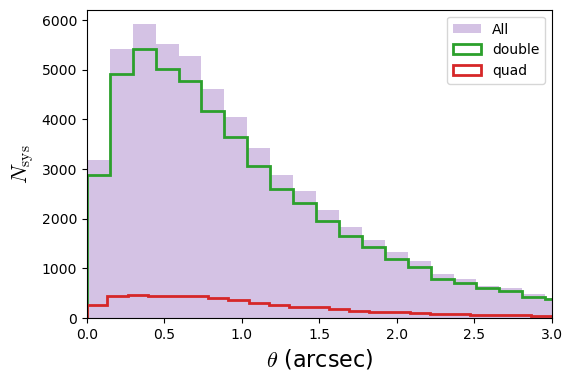

In [250]:
Unique_im_sep=im_sep[Unique_sys_ids]
idx_im2=np.where(Unique_im_counts==2)[0]
idx_im4=np.where(Unique_im_counts==4)[0]
im_sep2=Unique_im_sep[idx_im2]
im_sep4=Unique_im_sep[idx_im4]

Nbin=60
temp=plt.hist(Unique_im_sep,bins=Nbin,alpha=0.4, label=r"All",color=clrs[4])
temp=plt.hist(im_sep2,bins=Nbin,histtype='step',lw=2.0, label=r"double",color=clrs[2])
temp=plt.hist(im_sep4,bins=Nbin,histtype='step',lw=2.0, label=r"quad",color=clrs[3])
plt.xlim([0,3.0])
plt.legend()
plt.xlabel(r"$\theta$ (arcsec)")
plt.ylabel(r"$N_{\rm sys}$")
#plt.savefig(paper_out_dir+'Nsys_imsep0.pdf')
plt.show()

In [251]:
def get_sysN_im_sep(sysn,im_sep,image_sep_cut_arr):
    Nsep=len(image_sep_cut_arr)
    Tot_Nsys_unique, Nsys_unique_double, Nsys_unique_quad=np.zeros(Nsep),np.zeros(Nsep),np.zeros(Nsep)
    for ii,image_sep_cut in enumerate(image_sep_cut_arr):
        [Tot_Nsys_unique[ii], Nsys_unique_double[ii], Nsys_unique_quad[ii]],temp_data=get_numbers_doubles_quads(sysn[im_sep<=image_sep_cut])
        
    return Tot_Nsys_unique, Nsys_unique_double, Nsys_unique_quad

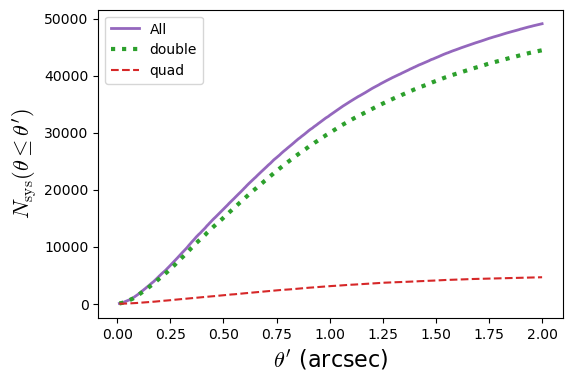

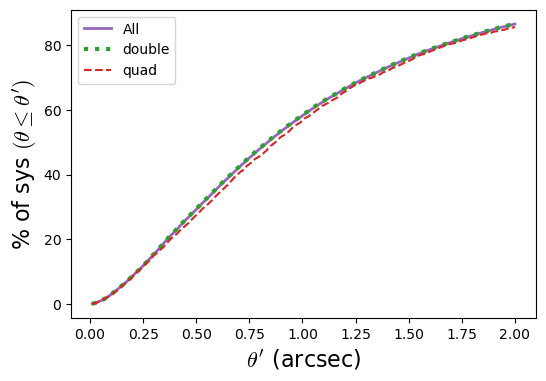

In [252]:
im_sep_cut_arr=np.linspace(0.01,2.0,1000)
Nsys_arr, Nsys_double, Nsys_quad=get_sysN_im_sep(sysn,im_sep,im_sep_cut_arr)
plt.plot(im_sep_cut_arr,Nsys_arr,lw=2.0, label=r"All",c=clrs[4])
plt.plot(im_sep_cut_arr,Nsys_double,ls='dotted',lw=3.0, label=r"double",c=clrs[2])
plt.plot(im_sep_cut_arr,Nsys_quad,ls='dashed', label=r"quad",c=clrs[3])

plt.xlabel(r"$\theta'$ (arcsec)")
plt.ylabel(r"$N_{\rm sys} (\theta \leq \theta')$")
#plt.yscale('log')
plt.legend()
plt.savefig(paper_out_dir+'Nsys_imsep1.pdf')
plt.show()

plt.plot(im_sep_cut_arr,100.0*Nsys_arr/Tot_Nsys_unique,lw=2.0, label=r"All",c=clrs[4])
plt.plot(im_sep_cut_arr,100.0*Nsys_double/Nsys_unique_double,ls='dotted',lw=3.0, label=r"double",c=clrs[2])
plt.plot(im_sep_cut_arr,100.0*Nsys_quad/Nsys_unique_quad,ls='dashed', label=r"quad",c=clrs[3])

plt.xlabel(r"$\theta'$ (arcsec)")
plt.ylabel(r"% of sys $(\theta \leq \theta')$")

plt.legend()
plt.savefig(paper_out_dir+'Nsys_imsep2.pdf')
plt.show()

In [253]:
t0=50
def get_lc_hsiao(t,z=0.4,band='lssti'):
    model = sncosmo.Model(source='hsiao')
    model.set(z=z, t0=t0, amplitude=1.e-5)
    flux=model.bandflux(band,t)
    
    return flux

def get_unresolved_peak_mag(z,mus,dts,smag):
#     if dts[0]!=0:
#         print('dts not in proper form..exiting')
#         #sys.exit()
    t=np.linspace(0,150,150)
    f0c=get_flux(smag)
    flux=get_lc_hsiao(t,z)
    flux=f0c*flux/flux.max()
    flux_interp=get_interp(t,flux)
    flux=np.zeros(len(t))
    for mu,dt in zip(mus,dts):
        flux=flux+mu*flux_interp(t-dt)
    return get_mag(flux.max())

def get_unresolved_flux(sysn_check):
    ids=np.where(sysn==sysn_check)[0]
    mus=magnification[ids]
    souce_mags=s_mag_I[ids]#-mag_deviation[ids]
    source_fluxes=get_flux(souce_mags)
    magnified_fluexs=source_fluxes*np.abs(mus)
    rough_unresolved_flux=np.sum(magnified_fluexs)
    rough_unresolved_mag=get_mag(rough_unresolved_flux)
    image_mags=get_mag(-np.sort(-magnified_fluexs))
    
    #print(source_fluxes)
    #print(mus)
    #print(get_mag(source_fluxes*np.abs(mus)))
    #return souce_mags,rough_unresolved_flux,rough_unresolved_mag,second_brightest_mag
    z=(s_z[ids])[0];dts=td[ids]
    #print(souce_mags,np.abs(mus),dts)
    unresolved_peak_mag=get_unresolved_peak_mag(z,np.abs(mus),dts,souce_mags[0])
    
    if len(mus)==2:
        return rough_unresolved_mag,unresolved_peak_mag,image_mags[1]
    else:
        ret=np.zeros(2+len(mus))
        ret[:2]=rough_unresolved_mag,unresolved_peak_mag
        ret[2:]=image_mags
        return ret

def rough_check(mus,smag):#do not use
    f0c=get_flux(smag)
    return get_mag(np.sum(np.abs(mus)*f0c))      

In [254]:
sysn_check=145
print(get_unresolved_flux(sysn_check))
# rough_check( [3.36384874 , 1.88300945 ],28.07)

[27.52253238 27.64758468 28.75013987 28.82055729 28.89297062 30.11764473]


In [255]:
double_sysn=Unique_sysn[idx_im2]
quad_sysn=Unique_sysn[idx_im4]

double_unres_secondBrightest_mag=np.zeros((len(idx_im2),3))
quad_unres_secondBrightest_mag=np.zeros((len(idx_im4),6))

for ii,sysi in enumerate(double_sysn):
    double_unres_secondBrightest_mag[ii]=get_unresolved_flux(sysi)
    
for ii,sysi in enumerate(quad_sysn):
    quad_unres_secondBrightest_mag[ii]=get_unresolved_flux(sysi)

In [256]:
def cal_im_sep(sysn_check,sysn=sysn,x_pos=x_pos,y_pos=y_pos,magnification=magnification):
    idxc=np.where(sysn==sysn_check)[0]
    mus=np.abs(magnification[idxc]); idx_sort_mu=np.argsort(-mus); idxc=idxc[idx_sort_mu]
    #print(im_sep[idxc], mus[idx_sort_mu])
    #print(im_sep[idxc])
    im_seps=[]
    xpos,ypos=x_pos[idxc],y_pos[idxc]; Nim=len(idxc)
    for ii in range(Nim):
        x1,y1=xpos[ii],ypos[ii]
        
        for jj in range(ii+1,Nim):
            x2,y2=xpos[jj],ypos[jj]
            sep=np.sqrt((x2-x1)**2+ (y2-y1)**2)
            im_seps.append(sep)
    return np.array(im_seps)
       
# sys_check=250
# im_seps_sys=cal_im_sep(sys_check)
# print(im_seps_sys,im_seps_sys.min(),im_seps_sys.max())
# idx_dq=np.where(sysn==sys_check)[0]
# print(data_cols[idx_dq,:])
# print(magnification[idx_dq])
# print(x_pos[idx_dq])
# print(y_pos[idx_dq])

def quad_find_if_res_or_unres(sys_check,quad_mag_data,LSST_mag_cut,im_sep_cut):
    t0,t1=quad_mag_data[:2]
    im_mags=quad_mag_data[2:]
    im_seps_sys=cal_im_sep(sys_check)
    
    if im_mags[0]>LSST_mag_cut or np.amax(im_seps_sys)<=im_sep_cut:
            return 0
    kk=0
    for ii,im_mag_i in enumerate(im_mags):
        #print('im_mag_i=',im_mag_i)
        if im_mag_i > LSST_mag_cut:
            #print('loop1',kk,im_mag_i)
            return 0
        else:
            for im_mag_j in im_mags[ii+1:]:
                #print('im_mag_j=',im_mag_j)
                if im_mag_j <=LSST_mag_cut and im_seps_sys[kk]>im_sep_cut:
                    #print("resolved:",im_mag_i,im_mag_j)
                    return 1
                else:
                    #print('kk=',kk)
                    kk+=1
    return -1
        

In [257]:
%%time

def get_res_unres_sys(LSST_mag_cut,im_sep_cut):
    Ndouble_resolved_detect=0
    Ndouble_unresolved_detect=0
    Nquad_resolved_detect=0
    Nquad_unresolved_detect=0
    unres_doubles=[]
    unres_quads=[]
    res_doubles=[]
    res_quads=[]
    
    for ii,sysi in enumerate(double_sysn):
        t0,t1,t2=double_unres_secondBrightest_mag[ii]
        if t1<=LSST_mag_cut and im_sep2[ii]<=im_sep_cut:
            Ndouble_unresolved_detect+=1
            unres_doubles.append(sysi)
        elif t2<=LSST_mag_cut and im_sep2[ii]>im_sep_cut:
            Ndouble_resolved_detect+=1
            res_doubles.append(sysi)
    for ii,sysi in enumerate(quad_sysn):        
        if quad_find_if_res_or_unres(sysi,quad_unres_secondBrightest_mag[ii],LSST_mag_cut,im_sep_cut):
            Nquad_resolved_detect+=1
            res_quads.append(sysi)
        elif (quad_unres_secondBrightest_mag[ii])[1]<=LSST_mag_cut and im_sep4[ii]<=im_sep_cut:
            Nquad_unresolved_detect+=1
            unres_quads.append(sysi)
            
    return [unres_doubles,unres_quads,res_doubles,res_quads],[Ndouble_unresolved_detect,Nquad_unresolved_detect,
                                                                 Ndouble_resolved_detect,Nquad_resolved_detect]
    

check_mag_cut,check_im_sep_cut=22.6,0.5    
[unres_doubles,unres_quads,res_doubles,res_quads],[Ndouble_unresolved_detect,Nquad_unresolved_detect,
                                                                 Ndouble_resolved_detect,Nquad_resolved_detect]=get_res_unres_sys(check_mag_cut,check_im_sep_cut)
Ndouble_unresolved_detect,Nquad_unresolved_detect,Ndouble_resolved_detect,Nquad_resolved_detect,len(unres_doubles),len(unres_quads),len(res_doubles),len(res_quads)

CPU times: user 335 ms, sys: 0 ns, total: 335 ms
Wall time: 334 ms


(571, 140, 189, 89, 571, 140, 189, 89)

In [258]:
LSST_mag_cut=22.6
NLSST_theta=71
LSST_im_sep_cut_arr=np.linspace(0.4,0.75,NLSST_theta);
Ndouble_resolved_detect_arr=np.zeros(NLSST_theta)
Ndouble_unresolved_detect_arr=np.zeros(NLSST_theta)
Nquad_resolved_detect_arr=np.zeros(NLSST_theta)
Nquad_unresolved_detect_arr=np.zeros(NLSST_theta)

for jj,im_sep_cut_i in enumerate(LSST_im_sep_cut_arr):
    unres_res_sys_data,[Ndouble_unresolved_detect_arr[jj],Nquad_unresolved_detect_arr[jj],
                                                                 Ndouble_resolved_detect_arr[jj],Nquad_resolved_detect_arr[jj]]=get_res_unres_sys(LSST_mag_cut,im_sep_cut_i)
    
            

*** LSST i-band limiting mag=22.6 ***


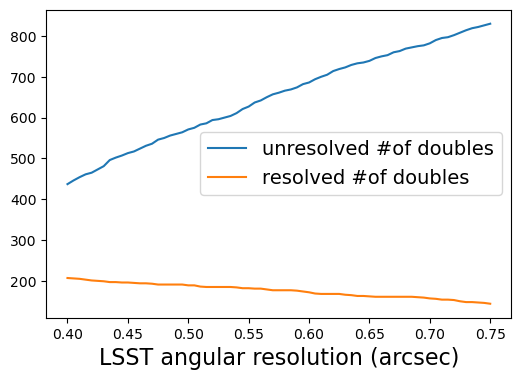

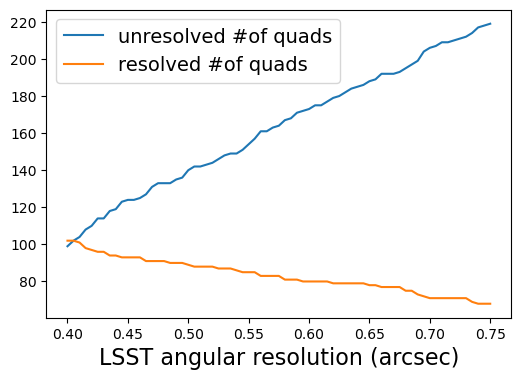

In [259]:
print("*** LSST i-band limiting mag=%s ***"%(LSST_mag_cut))
plt.plot(LSST_im_sep_cut_arr,Ndouble_unresolved_detect_arr,label=r"unresolved #of doubles")
plt.plot(LSST_im_sep_cut_arr,Ndouble_resolved_detect_arr,label=r"resolved #of doubles")
plt.xlabel(r"LSST angular resolution (arcsec)")
plt.legend(fontsize=14)
plt.savefig('res-unres_doubles.png',dpi=600)
plt.show()

plt.plot(LSST_im_sep_cut_arr,Nquad_unresolved_detect_arr,label=r"unresolved #of quads")
plt.plot(LSST_im_sep_cut_arr,Nquad_resolved_detect_arr,label=r"resolved #of quads")
#plt.plot(LSST_im_sep_cut_arr,Nquad_unresolved_detect_arr+Nquad_resolved_detect_arr,label=r"resolved #of doubles + quads")

plt.xlabel(r"LSST angular resolution (arcsec)")
plt.legend(fontsize=14)
plt.savefig('res-unres_quads.png',dpi=600)
plt.show()

In [260]:
Nquad_unresolved_detect_arr+Nquad_resolved_detect_arr

array([201., 204., 205., 206., 207., 210., 210., 212., 213., 216., 217.,
       217., 218., 218., 222., 224., 224., 223., 225., 226., 229., 230.,
       230., 231., 232., 233., 235., 236., 235., 236., 239., 242., 244.,
       244., 246., 247., 248., 249., 252., 252., 253., 255., 255., 257.,
       258., 259., 261., 263., 264., 265., 266., 267., 269., 269., 269.,
       270., 270., 272., 272., 276., 277., 278., 280., 280., 281., 282.,
       283., 283., 285., 286., 287.])

In [261]:
Nquad_unresolved_detect_arr,LSST_im_sep_cut_arr[-1]

(array([ 99., 102., 104., 108., 110., 114., 114., 118., 119., 123., 124.,
        124., 125., 127., 131., 133., 133., 133., 135., 136., 140., 142.,
        142., 143., 144., 146., 148., 149., 149., 151., 154., 157., 161.,
        161., 163., 164., 167., 168., 171., 172., 173., 175., 175., 177.,
        179., 180., 182., 184., 185., 186., 188., 189., 192., 192., 192.,
        193., 195., 197., 199., 204., 206., 207., 209., 209., 210., 211.,
        212., 214., 217., 218., 219.]),
 0.75)

In [262]:
#==== tot maginification study ============

711
[ 2.12460162  2.85826756  4.92726099 15.03191834 46.44545914]


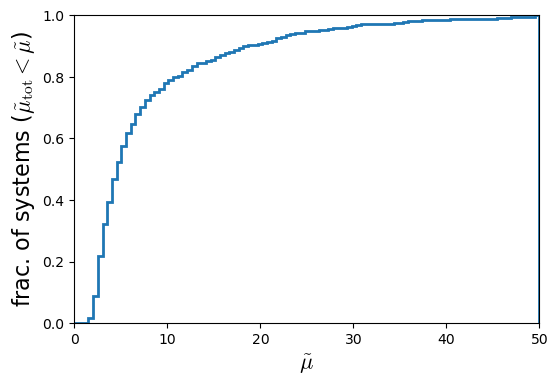

In [263]:

all_unres_sysn=unres_doubles+unres_quads; print(len(all_unres_sysn))

def get_magnifiction_from_mags(m1,m2):
    f1=get_flux(m1);f2=get_flux(m2)
    return f2/f1

def plot_tot_mag():
    tot_magnification_all,rough_tot_magnification_all=np.zeros(len(all_unres_sysn)),np.zeros(len(all_unres_sysn))
    for isys,sysid in enumerate(all_unres_sysn):
        unres_peak_res=get_unresolved_flux(sysid)
        ids=np.where(sysn==sysid)[0];mus=magnification[ids];souce_mag=(s_mag_I[ids])[0]
        unres_peak_mag=unres_peak_res[1]
        tot_magnification=get_magnifiction_from_mags(souce_mag,unres_peak_mag)
        rough_tot_magnification=np.sum(np.abs(mus))
        #print(tot_magnification,rough_tot_magnification)
        tot_magnification_all[isys]=tot_magnification
        rough_tot_magnification_all[isys]=rough_tot_magnification

    binsd=np.linspace(0,50,100)
    plt.hist(tot_magnification_all,bins=binsd,cumulative=True,histtype='step',density=True,lw=2.0)
    #plt.hist(rough_tot_magnification_all,bins=20,histtype='step')
    plt.xlim([0,50])
    plt.ylim([0,1])
    plt.ylabel(r"frac. of systems ($\tilde{\mu}_{\rm tot}<\tilde{\mu}$)")
    plt.xlabel(r"$\tilde{\mu}$")
    #plt.savefig(paper_out_dir+"tot_magnification_dist.pdf")
    return tot_magnification_all
tot_magnification_all=plot_tot_mag()
print(np.percentile(tot_magnification_all,[2.5,16.0,50.0,84.0,97.5]))

In [264]:
#new  microlesning implementation 4_24


(250, 16)
98 152
87
49 38


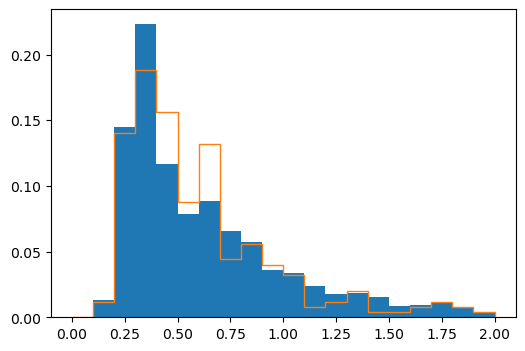

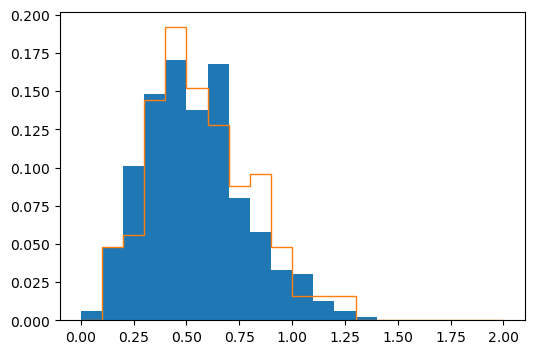

In [265]:
#stored ascii files
all_good_downsampled_data=np.loadtxt(catalog_dir+'down_sampled_data/'+'All_good_downsample.txt')
print(all_good_downsampled_data.shape)
idx2=np.where(all_good_downsampled_data[:,1]==2)[0]
idx4=np.where(all_good_downsampled_data[:,1]==4)[0]
print(len(idx2/2),len(idx4/4))

only_sysn_ni_data=np.loadtxt(catalog_dir+'down_sampled_data/'+'all_good_sys.txt')
print(len(only_sysn_ni_data[:,0]))
sysn_list_double=(only_sysn_ni_data[:,0])[only_sysn_ni_data[:,1]==2.]
sysn_list_quad=(only_sysn_ni_data[:,0])[only_sysn_ni_data[:,1]==4.]
print(len(sysn_list_double),len(sysn_list_quad))


def plot_hist_percentage(data,xlabel=None,ylabel=None,histtyep='bar',bins=20, legend=None):
    if legend:
        plt.hist(data, weights=np.ones(len(data)) / len(data),histtype=histtyep,bins=bins,label=legend)
    else:
        plt.hist(data, weights=np.ones(len(data)) / len(data),histtype=histtyep,bins=bins)
    if xlabel: 
        plt.xlabel(xlabel)
    if ylabel: 
        plt.ylabel(ylabel)
        
#All LSST unres systems:
all_lsst_unres_sys=np.loadtxt(catalog_dir+'Unresolved_LSNeIa_Imag_cut22.6_theta_cut0.5.txt')

all_sysn,unique_id=np.unique(all_lsst_unres_sys[:,0],return_index=True)
NIss=all_lsst_unres_sys[unique_id,1]

all_double_list=np.unique((all_lsst_unres_sys[:,0])[all_lsst_unres_sys[:,1]==2])
all_quad_list=np.unique((all_lsst_unres_sys[:,0])[all_lsst_unres_sys[:,1]==4])



kappa_all,gamma_all,lens_z_all,s_z_all=all_lsst_unres_sys[:,2],all_lsst_unres_sys[:,3],all_lsst_unres_sys[:,5],all_lsst_unres_sys[:,4]
simon_good_kappa,simon_good_gamma,simon_good_lens_z,simon_good_s_z=all_good_downsampled_data[:,2],all_good_downsampled_data[:,3],all_good_downsampled_data[:,5],all_good_downsampled_data[:,4]
binsd=np.linspace(0,2,21)
plot_hist_percentage(gamma_all,bins=binsd,histtyep='bar')
plot_hist_percentage(simon_good_gamma,bins=binsd,histtyep='step')
plt.show()
plot_hist_percentage(lens_z_all,bins=binsd,histtyep='bar')
plot_hist_percentage(simon_good_lens_z,bins=binsd,histtyep='step')

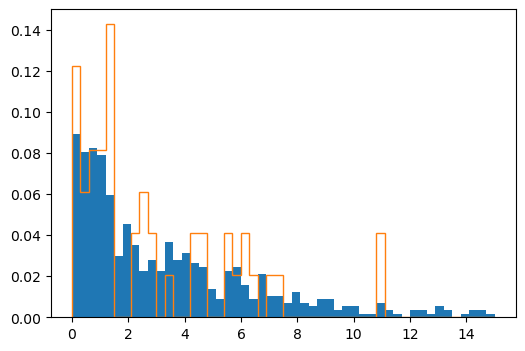

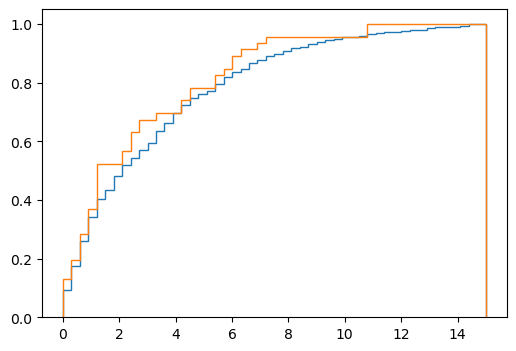

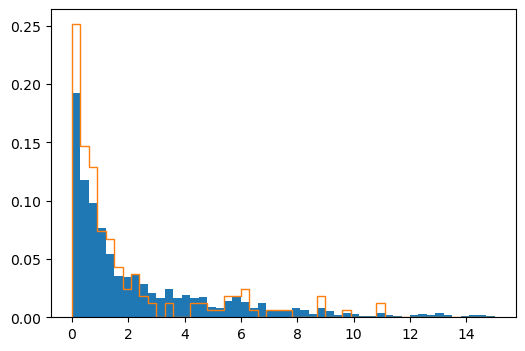

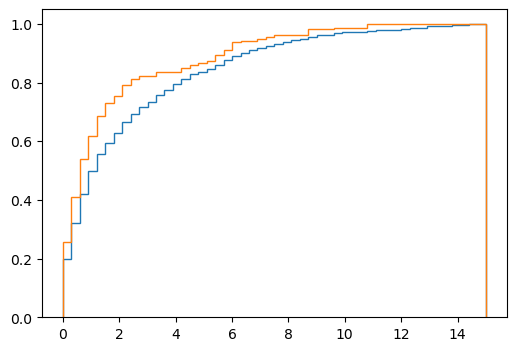

In [266]:
def get_mu_dt(sys_data):
    dts_sys=sys_data[:,6]; idx=np.argsort(dts_sys);dts_sys=dts_sys[idx];dts_sys=(dts_sys-dts_sys[0])
    mus_sys=np.abs(sys_data[:,7]);mus_sys=mus_sys[idx];mus_sys=mus_sys/mus_sys[0]
    return dts_sys[1:],mus_sys[1:]

def get_data_for_sysni(sysni,set_data):
    idx=np.where(all_lsst_unres_sys[:,0]==sysni)[0]
    if len(idx)>0:
        return set_data[idx,:]
    else:
        raise ValueError('system %d not found'%(sysni))
        
mus_list=[];dts_list=[]
mus_list_simon_good=[];dts_list_simon_good=[]

all_double_list=np.unique((all_lsst_unres_sys[:,0])[all_lsst_unres_sys[:,1]==2])
all_quad_list=np.unique((all_lsst_unres_sys[:,0])[all_lsst_unres_sys[:,1]==4])

for ii,sysni in enumerate(all_double_list):
    sysni_data= get_data_for_sysni(sysni,all_lsst_unres_sys)
    dts_sysni,mus_sysni=get_mu_dt(sysni_data);mus_list.extend(mus_sysni);dts_list.extend(dts_sysni)

#simon good simulated list
for ii,sysni in enumerate(sysn_list_double):
    sysni_data= get_data_for_sysni(sysni,all_lsst_unres_sys)
    dts_sysni,mus_sysni=get_mu_dt(sysni_data);mus_list_simon_good.extend(mus_sysni);dts_list_simon_good.extend(dts_sysni)
    
binsd=np.linspace(0,15,51)
plot_hist_percentage(dts_list,bins=binsd,histtyep='bar')
plot_hist_percentage(dts_list_simon_good,bins=binsd,histtyep='step')
plt.show()

plt.hist(dts_list,cumulative=True,histtype='step',density=True,bins=binsd)
plt.hist(dts_list_simon_good,cumulative=True,histtype='step',density=True,bins=binsd)
plt.show()

for ii,sysni in enumerate(all_quad_list):
    sysni_data= get_data_for_sysni(sysni,all_lsst_unres_sys)
    dts_sysni,mus_sysni=get_mu_dt(sysni_data);mus_list.extend(mus_sysni);dts_list.extend(dts_sysni)
#simon good simulated list
for ii,sysni in enumerate(sysn_list_quad):
    sysni_data= get_data_for_sysni(sysni,all_lsst_unres_sys)
    dts_sysni,mus_sysni=get_mu_dt(sysni_data);mus_list_simon_good.extend(mus_sysni);dts_list_simon_good.extend(dts_sysni)
    
binsd=np.linspace(0,15,51)
plot_hist_percentage(dts_list,bins=binsd,histtyep='bar')
plot_hist_percentage(dts_list_simon_good,bins=binsd,histtyep='step')
plt.show()
plt.hist(dts_list,cumulative=True,histtype='step',density=True,bins=binsd)
plt.hist(dts_list_simon_good,cumulative=True,histtype='step',density=True,bins=binsd)
plt.show()
    

In [267]:
micro_mag_dir='./save_micro_mag_res/'
all_ml_sys=only_sysn_ni_data[:,0]#np.hstack((sysn_list_double,sysn_list_quad));print(len(all_ml_sys))
modelname,band='ww','i'
micro_mag_dist_dict={}

for ii, sysni in enumerate(all_ml_sys):
    ni_sys=only_sysn_ni_data[ii,1].astype('int')
    for imi in range(ni_sys):
        key_name='sysn%d_im%d'%(sysni,imi)
        fmicro=micro_mag_dir+'sysn%d_im%d_model_%s_band_%s.txt'%(sysni,imi+1,modelname,band)
        micro_mag_dist=np.loadtxt(fmicro)
        micro_mag_dist_dict[key_name]=micro_mag_dist
with open(micro_mag_dir+'all_micro_mag_dist_model_%s_band_%s'%(modelname,band), 'wb') as f:
    pickle.dump(micro_mag_dist_dict, f)    

In [268]:
def get_nearest_neighbour(data1,data2):
    k1,g1,sz1,lz1=data1
    k2,g2,sz2,lz2=data2
    kg_dist=np.sqrt((k2-k1)**2+(g2-g1)**2)
    ls_z_dist=np.sqrt((sz2-sz1)**2+(lz2-lz1)**2)
    return np.sum(kg_dist),np.sum(ls_z_dist)

def get_data_for_sysni(sysni,set_data):
    idx=np.where(set_data[:,0]==sysni)[0]
    if len(idx)>0:
        return set_data[idx,:]
    else:
        #print('bad',sysni)
        raise ValueError('system %d not found'%(sysni[0]))

def find_best_matching_sys_id(dist_data):
    sys_id1=np.argmin(dist_data[:,0]**2+dist_data[:,1]**2)
    sys_id2=np.argmin(dist_data[:,0])
    sys_id3=np.argmin(dist_data[:,1])
    return sys_id1,sys_id2,sys_id3
def get_simon_good_sys_id(sysni,set_data,set_data_relevant_ids=np.arange(2,6)):
#     if sysni in only_sysn_ni_data[:,0]:
#         return sysni
    sysni_data= get_data_for_sysni(sysni,set_data)
    ki,gi,s_zi,l_zi=sysni_data[:,set_data_relevant_ids[0]],sysni_data[:,set_data_relevant_ids[1]],sysni_data[:,set_data_relevant_ids[2]],sysni_data[:,set_data_relevant_ids[3]]
    datai=ki,gi,s_zi,l_zi
    NIi=len(ki); print(NIi)
    
    if NIi==2:
        serach_list=sysn_list_double
    elif NIi==4:
        serach_list=sysn_list_quad
    else:
        raise ValueError('NI=',NIi,'sysni=',sysni)
    Nj=len(serach_list)
    dist_data=np.zeros((Nj,2))
    for jj,sysnj in enumerate(serach_list):
        sysnj_data= get_data_for_sysni(sysnj,all_good_downsampled_data)
        kj,gj,s_zj,l_zj=sysnj_data[:,2],sysnj_data[:,3],sysnj_data[:,4],sysnj_data[:,5]
        dataj=kj,gj,s_zj,l_zj
        kg_dist,ls_z_dist=get_nearest_neighbour(datai,dataj)
        #print(jj,kg_dist,ls_z_dist)
        dist_data[jj,:]=kg_dist,ls_z_dist
    #print('dist_data',dist_data)
    sys_id1,sys_id2,sys_id3=find_best_matching_sys_id(dist_data)
    print('best matching systems',serach_list[sys_id1],serach_list[sys_id2],serach_list[sys_id3])
    print('dustances-->',dist_data[sys_id1],dist_data[sys_id2],dist_data[sys_id3],'\n\n')
    print('(target) i sys->',ki,gi,s_zi,l_zi)
    sysnj_found_data= get_data_for_sysni(serach_list[sys_id1],all_good_downsampled_data)
    kj,gj,s_zj,l_zj=sysnj_found_data[:,2],sysnj_found_data[:,3],sysnj_found_data[:,4],sysnj_found_data[:,5]
    print('(found) i sys->',kj,gj,s_zj,l_zj)
    print('\n\n\n')
    #print(serach_list)
    return serach_list[sys_id1]
    
#sysnj=get_simon_good_sys_id(sysni,all_lsst_unres_sys)


In [269]:

#loop through all (doubles+quads) SNeIa
target_sysn_for_micro=np.zeros(len(Unique_sysn))

original_stdout = sys.stdout

sys.stdout = open(os.devnull, 'w')
for ii,unique_sysn_i in enumerate(Unique_sysn): 
    target_sysn_for_micro[ii]=get_simon_good_sys_id(unique_sysn_i,data_cols,[7,8,3,4])
sys.stdout.close()
sys.stdout = original_stdout

In [270]:
target_sysn_for_micro[Unique_sysn==all_ml_sys[-24]],all_ml_sys[-24]

(array([21758.]), 21758.0)

In [271]:
def get_unresolved_peak_mag2(z,mus,dts,smag,micro_mags):
#     if dts[0]!=0:
#         print('dts not in proper form..exiting')
#         #sys.exit()
    Ntt=150
    t=np.linspace(0,150,Ntt)
    f0c=get_flux(smag)
    flux=get_lc_hsiao(t,z)
    flux=f0c*flux/flux.max()
    flux_interp=get_interp(t,flux)
    mag_peak_list=[]
    flux_arr=np.zeros((len(mus),Ntt))
    
    kk=0
    for mu,dt in zip(mus,dts):
        flux_arr[kk]=mu*flux_interp(t-dt)
        kk+=1
    for jj in range(Nmicro):
        flux_arr_jj=(micro_mags[jj])[:,np.newaxis]*flux_arr
        unres_flux_jj=np.sum(flux_arr_jj,axis=0)
        mag_peak_list.append(get_mag(unres_flux_jj.max()))
    
    
#     for jj in range(Nmicro):
#         flux=np.zeros(len(t))
#         for mu,dt in zip(macro_micro_mags[jj],dts):
#             flux=flux+mu*flux_interp(t-dt)
#         mag_peak_list.append(get_mag(flux.max()))
    return np.array(mag_peak_list)

def get_Nmciro_micro_magnifications(target_sys,NI_sys_check,Nmicro):
    ret=np.zeros((Nmicro,NI_sys_check))
    for imi in range(NI_sys_check):
        key_name='sysn%d_im%d'%(target_sys,imi)
        micro_mag_dist=micro_mag_dist_dict[key_name];micro_mag_dist= micro_mag_dist/np.mean(micro_mag_dist)
        ret[:,imi]=np.random.choice(micro_mag_dist,Nmicro, replace=False)
    return ret

def get_unresolved_flux2(sysn_check):
    #print('entered')
    ids=np.where(sysn==sysn_check)[0]; NI_sys_check=len(ids)
    if NI_sys_check not in [2,4]:
        raise ValueError('something went wrong, NI=',NI_sys_check)
    mus=np.abs(magnification[ids])
    #print('sata',ids)
    souce_mags=s_mag_I[ids]#-mag_deviation[ids]
    source_fluxes=get_flux(souce_mags)
    magnified_fluexs=source_fluxes*np.abs(mus)
    
    target_sys=target_sysn_for_micro[Unique_sysn==sysn_check]

    
    
    #micro_magni_sam=get_micro_peak_magni_dist(inv_cdf_magni_interp,N=(Nmicro,len(mus)))
    micro_magni_sam=get_Nmciro_micro_magnifications(target_sys,NI_sys_check,Nmicro)
    #micro_magni_sam=np.clip(np.random.normal(1.0,0.5,(Nmicro,NI_sys_check)),0.01,None)#np.ones((Nmicro,NI_sys_check))
#     print(micro_magni_sam,micro_magni_sam1)
#     print(micro_magni_sam.shape,micro_magni_sam1.shape)
#     print(np.mean(micro_magni_sam),np.mean(micro_magni_sam1))
#     print(np.median(micro_magni_sam),np.median(micro_magni_sam1))
    macro_micro_mags=mus[np.newaxis,:]*micro_magni_sam

    
    macro_micro_image_mags=source_fluxes[np.newaxis,:]*macro_micro_mags
    
    rough_unresolved_flux=np.sum(macro_micro_image_mags,axis=1)
    rough_unresolved_mag=get_mag(rough_unresolved_flux)
    image_mags=get_mag(-np.sort(-macro_micro_image_mags,axis=1))
    #print(image_mags.shape)

    #print(source_fluxes)
    #print(mus)
    #print(get_mag(source_fluxes*np.abs(mus)))
    #return souce_mags,rough_unresolved_flux,rough_unresolved_mag,second_brightest_mag
    z=(s_z[ids])[0];dts=td[ids]; #dts=[0,0]
    #print(souce_mags,np.abs(mus),dts)
    unresolved_peak_mag=get_unresolved_peak_mag2(z,mus,dts,souce_mags[0],micro_magni_sam)
    
    #print(mus,dts)
    
    
    if len(mus)==2:
        return np.c_[rough_unresolved_mag,unresolved_peak_mag,image_mags[:,1]]
    else:
        ret=np.zeros((Nmicro,2+len(mus)))
        ret[:,0]=rough_unresolved_mag
        ret[:,1]=unresolved_peak_mag
        ret[:,2:]=image_mags
        return ret

In [272]:
Nmicro=100

time1=time.time()

double_sysn=Unique_sysn[idx_im2]
quad_sysn=Unique_sysn[idx_im4]

double_unres_secondBrightest_mag2=np.full((Nmicro*len(idx_im2),3),np.nan)
quad_unres_secondBrightest_mag2=np.full((Nmicro*len(idx_im4),6),np.nan)

for ii,sysi in enumerate(double_sysn):
    double_unres_secondBrightest_mag2[Nmicro*ii:Nmicro*(ii+1)]=get_unresolved_flux2(sysi)
    
for ii,sysi in enumerate(quad_sysn):
    quad_unres_secondBrightest_mag2[Nmicro*ii:Nmicro*(ii+1)]=get_unresolved_flux2(sysi)
print("elasped time=",time.time()-time1)

/tmp/ipykernel_4034426/604515363.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  key_name='sysn%d_im%d'%(target_sys,imi)


elasped time= 82.06037449836731


In [ ]:
%%time
def get_res_unres_sys2(LSST_mag_cut,im_sep_cut,dummy_data):
    double_unres_secondBrightest_mag,quad_unres_secondBrightest_mag=dummy_data
    Ndouble_resolved_detect=0
    Ndouble_unresolved_detect=0
    Nquad_resolved_detect=0
    Nquad_unresolved_detect=0
    unres_doubles=[]
    unres_quads=[]
    res_doubles=[]
    res_quads=[]
    
    for ii,sysi in enumerate(double_sysn):
        for jj in range(Nmicro):
            t0,t1,t2=double_unres_secondBrightest_mag[ii*Nmicro+jj]
            if t1<=LSST_mag_cut and im_sep2[ii]<=im_sep_cut:
                Ndouble_unresolved_detect+=1
                unres_doubles.append(sysi)
            elif t2<=LSST_mag_cut and im_sep2[ii]>im_sep_cut:
                Ndouble_resolved_detect+=1
                res_doubles.append(sysi)
    for ii,sysi in enumerate(quad_sysn):
        for jj in range(Nmicro):
            if (quad_unres_secondBrightest_mag[ii*Nmicro+jj])[1]<=LSST_mag_cut and im_sep4[ii]<=im_sep_cut:
                Nquad_unresolved_detect+=1
                unres_quads.append(sysi)

            elif quad_find_if_res_or_unres(sysi,quad_unres_secondBrightest_mag[ii*Nmicro+jj],LSST_mag_cut,im_sep_cut):
                Nquad_resolved_detect+=1
                res_quads.append(sysi)
            
    return [unres_doubles,unres_quads,res_doubles,res_quads],[Ndouble_unresolved_detect,Nquad_unresolved_detect,
                                                                 Ndouble_resolved_detect,Nquad_resolved_detect]


dummy_data=double_unres_secondBrightest_mag2,quad_unres_secondBrightest_mag2

LSST_mag_cut=22.6
NLSST_theta=71
LSST_im_sep_cut_arr=np.linspace(0.4,0.75,NLSST_theta);
Ndouble_resolved_detect_arr2=np.zeros(NLSST_theta)
Ndouble_unresolved_detect_arr2=np.zeros(NLSST_theta)
Nquad_resolved_detect_arr2=np.zeros(NLSST_theta)
Nquad_unresolved_detect_arr2=np.zeros(NLSST_theta)

for jj,im_sep_cut_i in enumerate(LSST_im_sep_cut_arr):
    unres_res_sys_data2,[Ndouble_unresolved_detect_arr2[jj],Nquad_unresolved_detect_arr2[jj],
                                                                 Ndouble_resolved_detect_arr2[jj],Nquad_resolved_detect_arr2[jj]]=get_res_unres_sys2(LSST_mag_cut,im_sep_cut_i,dummy_data)

In [ ]:
def has_nan(arr):
    return np.isnan(arr).any()
has_nan(quad_unres_secondBrightest_mag2),has_nan(double_unres_secondBrightest_mag2)

In [ ]:
print(" *** Definition of resolved: any two images: (i) separation > theta_th, (ii) brighter than LSST limiting mag")

print("\n *** Definition of unresolved: (i) max sepration < theta_th and (ii) combined flux brighter than LSST limiting mag\n")
print("*** LSST i-band limiting mag=%s ***"%(LSST_mag_cut))
plt.plot(LSST_im_sep_cut_arr,Ndouble_unresolved_detect_arr2/Nmicro,label=r"unresolved #of doubles")
plt.plot(LSST_im_sep_cut_arr,Ndouble_unresolved_detect_arr,c=clrs[0],ls='--')
plt.plot(LSST_im_sep_cut_arr,Ndouble_resolved_detect_arr2/Nmicro,c=clrs[1],label=r"resolved #of doubles")
plt.plot(LSST_im_sep_cut_arr,Ndouble_resolved_detect_arr,c=clrs[1],ls='--')
plt.xlabel(r"LSST angular resolution (arcsec)")
plt.legend(fontsize=14)
plt.show()

plt.plot(LSST_im_sep_cut_arr,Nquad_unresolved_detect_arr2/Nmicro,c=clrs[0],label=r"unresolved #of quads")
plt.plot(LSST_im_sep_cut_arr,Nquad_unresolved_detect_arr,c=clrs[0],ls='--')
plt.plot(LSST_im_sep_cut_arr,Nquad_resolved_detect_arr2/Nmicro,c=clrs[1],label=r"resolved #of quads")
plt.plot(LSST_im_sep_cut_arr,Nquad_resolved_detect_arr,c=clrs[1],ls='--')
#plt.plot(LSST_im_sep_cut_arr,(Nquad_unresolved_detect_arr2+Nquad_resolved_detect_arr2)/Nmicro,label=r"resolved #of doubles + quads")

plt.xlabel(r"LSST angular resolution (arcsec)")
plt.legend(fontsize=14)
print("solid (dashed) = with (without) microlensing")
plt.show()

In [ ]:
len(Ndouble_unresolved_detect_arr)

In [ ]:
#total:
plt.rcParams['legend.title_fontsize'] = 13
N_unres_ml=(Ndouble_unresolved_detect_arr2+Nquad_unresolved_detect_arr2)/Nmicro
N_res_ml=(Ndouble_resolved_detect_arr2+Nquad_resolved_detect_arr2)/Nmicro

N_unres=(Ndouble_unresolved_detect_arr+Nquad_unresolved_detect_arr)
N_res=(Ndouble_resolved_detect_arr+Nquad_resolved_detect_arr)

plt.plot(LSST_im_sep_cut_arr,N_unres,c=clrs[0],label=r"unresolved")
plt.plot(LSST_im_sep_cut_arr,N_unres_ml,c=clrs[0],ls='--')

plt.plot(LSST_im_sep_cut_arr,N_res,c=clrs[1],label=r"resolved")
plt.plot(LSST_im_sep_cut_arr,N_res_ml,c=clrs[1],ls='--')

#plt.plot(LSST_im_sep_cut_arr,(Nquad_unresolved_detect_arr2+Nquad_resolved_detect_arr2)/Nmicro,label=r"resolved #of doubles + quads")


print("solid (dashed) = with (without) microlensing")

theta_psf=0.75; res_theta=2*theta_psf/3.0
plt.scatter([res_theta,],[711])
plt.scatter([res_theta,],[278])
y1,y2=plt.ylim()
plt.plot([res_theta,res_theta],[y1,y2],ls="--",c="k",lw=2.0,alpha=0.5)

plt.xlabel(r"$\theta_{\rm crit}$ (arcsec)")
plt.ylabel("No. of lensed SNe1A")
#plt.legend(title=r"i-band observation" +"\n"+r"resolved: $\theta_{sep}$ > $\theta_{th}$",fontsize=12)
plt.legend(fontsize=12)

#plt.xlim([0.4,0.6])
plt.ylim([175,900])

ax=plt.gca()
#plt.text(0.18,0.7,r"$(2/3)\theta_{\rm psf}$",rotation=90, transform=ax.transAxes,fontsize=12)
plt.text(0.52,0.35,r"$\theta_{th}\sim (2/3)\theta_{\rm psf}$",rotation=90, transform=ax.transAxes,fontsize=11)
ax.set_xticks([0.4,0.45,0.5,0.55,0.6])


#plt.title(r"LSST 10 year observation")
#plt.savefig('res_unres2.png',dpi=1000, transparent=True)
#plt.savefig(paper_out_dir+'res_unres.pdf')

plt.show()

In [ ]:
#total:
obs_factor=0.1
plt.rcParams['legend.title_fontsize'] = 13
N_unres_ml=(Ndouble_unresolved_detect_arr2+Nquad_unresolved_detect_arr2)/Nmicro
N_res_ml=(Ndouble_resolved_detect_arr2+Nquad_resolved_detect_arr2)/Nmicro

N_unres=(Ndouble_unresolved_detect_arr+Nquad_unresolved_detect_arr)
N_res=(Ndouble_resolved_detect_arr+Nquad_resolved_detect_arr)

plt.plot(LSST_im_sep_cut_arr,obs_factor*N_unres,c=clrs[0],label=r"unresolved",lw=2.0)
plt.plot(LSST_im_sep_cut_arr,obs_factor*N_unres_ml,c=clrs[0],ls='--',lw=2.0)

plt.plot(LSST_im_sep_cut_arr,obs_factor*N_res,c=clrs[1],label=r"resolved",lw=2.0)
plt.plot(LSST_im_sep_cut_arr,obs_factor*N_res_ml,c=clrs[1],ls='--',lw=2.0)

#plt.plot(LSST_im_sep_cut_arr,(Nquad_unresolved_detect_arr2+Nquad_resolved_detect_arr2)/Nmicro,label=r"resolved #of doubles + quads")


print("solid (dashed) = with (without) microlensing")

theta_psf=0.75; res_theta=2*theta_psf/3.0
plt.scatter([res_theta,],[711*obs_factor])
plt.scatter([res_theta,],[278*obs_factor])
y1,y2=plt.ylim()
plt.plot([res_theta,res_theta],[y1,y2],ls="--",c="k",lw=2.0,alpha=0.5)

plt.xlabel(r"$\theta_{\rm crit}$ (arcsec)")
plt.ylabel("No. of lensed SNe Ia")
#plt.legend(title=r"i-band observation" +"\n"+r"resolved: $\theta_{sep}$ > $\theta_{th}$",fontsize=12)
plt.legend(fontsize=12)

plt.xlim([0.4,0.6])
plt.ylim([15,90])

ax=plt.gca()
#plt.text(0.18,0.7,r"$(2/3)\theta_{\rm psf}$",rotation=90, transform=ax.transAxes,fontsize=12)
plt.text(0.52,0.35,r"$\theta_{th}\sim (2/3)\theta_{\rm psf}$",rotation=90, transform=ax.transAxes,fontsize=11)
ax.set_xticks([0.4,0.45,0.5,0.55,0.6])


#plt.title(r"LSST 10 year observation")

#plt.savefig(paper_out_dir+'New_res_unres11.pdf')

plt.legend(fontsize=12)
#plt.savefig('res_unres311.png',dpi=1000, transparent=True)

plt.show()

In [ ]:
N_res[LSST_im_sep_cut_arr==0.5],N_res_ml[LSST_im_sep_cut_arr==0.5],N_unres[LSST_im_sep_cut_arr==0.5],N_unres_ml[LSST_im_sep_cut_arr==0.5]

In [ ]:
#=========== end using micro lensing realisations ==============================

In [ ]:
#kappa.gamma to magnification:
def get_magnification_from_kappa_gamma(kappa,gamma):
    return (1.0/((1.0-kappa)**2-gamma**2))

k_vals=np.linspace(0, 3.2, 100)
g_vals=np.linspace(0, 3.2, 100)
k_grid,g_grid=np.meshgrid(k_vals, g_vals)
magnification_grid = np.log10(np.abs(get_magnification_from_kappa_gamma(k_grid,g_grid)))

plt.pcolormesh(k_grid,g_grid, magnification_grid, shading='auto', cmap='plasma',vmin=-1.0, vmax=1.0)
plt.colorbar(label=r'$\log_{10}(|\mu (\kappa, \gamma)|)$')  # Add a colorbar to the plot

plt.xlabel(r'$\kappa$')
plt.ylabel(r'$\gamma$')
#plt.title('2D Color Plot of f(x, y)')
# corner.hist2d(kappa[idx_unres],gamma[idx_unres], bins=40, 
#               range=[[0,3.2],[0,3.2]],levels=(0.95,), smooth=1.4, ax=None, color=None, 
#               quiet=False, plot_datapoints=False, plot_density=False, plot_contours=True, 
#               no_fill_contours=True, fill_contours=False)

plt.plot([0,3.2],[0,3.2],ls="--",c="k")
print(get_magnification_from_kappa_gamma(np.array([0.0,0.3,1.0,1.5,2.0]),np.array([0.0,0.3,1.0,1.5,2.0])))
plt.show()

In [ ]:
def plot_hist_percentage(data,xlabel=None,ylabel=None,histtyep='bar',bins=20, legend=None):
    if legend:
        plt.hist(data, weights=np.ones(len(data)) / len(data),histtype=histtyep,bins=bins,label=legend)
    else:
        plt.hist(data, weights=np.ones(len(data)) / len(data),histtype=histtyep,bins=bins)
    if xlabel: 
        plt.xlabel(xlabel)
    if ylabel: 
        plt.ylabel(ylabel)
        

In [ ]:
def overplot_magnification_map_k_g(res_sam,unres_sam,labels =[r"$\kappa$",r"$\gamma$"],plot_range=[[0,3.2],[0,3.2]],savename=None, plot_ds=None):
    Nbin_cm=100
    k_vals=np.linspace(plot_range[0][0],plot_range[0][1], Nbin_cm)
    g_vals=np.linspace(plot_range[0][0],plot_range[0][1], Nbin_cm)
    k_grid,g_grid=np.meshgrid(k_vals, g_vals)
    magnification_grid = np.log10(np.abs(get_magnification_from_kappa_gamma(k_grid,g_grid)))

    plt.pcolormesh(k_grid,g_grid, magnification_grid, shading='auto', cmap='plasma',vmin=-1.0, vmax=1.0)
    plt.colorbar(label=r'$\log_{10}(|\tilde{\mu} (\kappa, \gamma)|)$')  # Add a colorbar to the plot

    plt.xlabel(r'$\kappa$')
    plt.ylabel(r'$\gamma$')
    #plt.title('2D Color Plot of f(x, y)')
    corner.hist2d(unres_sam[:,0],unres_sam[:,1], bins=30, 
                  range=plot_range,levels=(0.95,), smooth=0.5, ax=None, color=clrs[0], 
                  quiet=False, plot_datapoints=False, plot_density=False, plot_contours=True, 
                  no_fill_contours=True, fill_contours=False)
    corner.hist2d(res_sam[:,0],res_sam[:,1], bins=30, 
                  range=plot_range,levels=(0.95,), smooth=0.5, ax=None, color=clrs[1], 
                  quiet=False, plot_datapoints=False, plot_density=False, plot_contours=True, 
                  no_fill_contours=True, fill_contours=False)

    plt.plot(plot_range[0],plot_range[0],ls="--",c="k")
    if plot_ds:
        iidx2=np.where(all_good_downsampled_data[:,1]==2)[0]
        iidx2=np.where(all_good_downsampled_data[:,1]==2)[0]
        plt.scatter(all_good_downsampled_data[idx2,2],all_good_downsampled_data[idx2,3],c=clrs[2],marker='o',s=6.0)
        plt.scatter(all_good_downsampled_data[idx4,2],all_good_downsampled_data[idx4,3],c=clrs[3],marker='s',s=5.0,alpha=0.75)
        #plt.xlabel(r"$\kappa$");plt.xlabel(r"$\gamma$")
    if savename:
        plt.savefig(out_dir+savename+'.png',dpi=1200,transparent=True)
        plt.savefig(paper_out_dir+savename+'.pdf')
    plt.show()

In [ ]:
all_good_downsampled_data

In [ ]:
CORNER_KWARGS = dict(
    smooth=1.5,
    labels =[r"$\kappa$",r"$\gamma$"],
    #quantiles=[0.16, 0.84],
    #range=[[0.27,0.335],[66.0,73.0]],
    bins=30,
    levels=(0.68,0.95),
    plot_density=False,
    plot_datapoints=False,
    fill_contours=True,
    show_titles=False,
    max_n_ticks=4,
    labelpad=-0.1
)
CORNER_KWARGS.update(range=[[0,3.2],[0,3.2]])

In [ ]:
out_dir='./out_dir/'

In [ ]:
def get_flat_smaples(A,B):
    return np.vstack((A.flatten(),B.flatten())).T

def plot_corner_res_vs_unres(res_sam,unres_sam,labels =[r"$\kappa$",r"$\gamma$"],plot_range=[[0,3.2],[0,3.2]]):
    CORNER_KWARGS.update(range=plot_range)
    CORNER_KWARGS.update(labels=labels)
    fig=corner.corner(
        unres_sam,hist_kwargs=dict(density=True),
        color=clrs[0],
        **CORNER_KWARGS
    )
    
    
    fig=corner.corner(
        res_sam,hist_kwargs=dict(density=True),
        color=clrs[1],fig=fig,
        **CORNER_KWARGS
    )
    
    return fig


LSST_theta=0.5
idx_unres=np.where(im_sep<=LSST_theta)[0]
idx_res=np.where(im_sep>LSST_theta)[0]
binsd=np.linspace(0,2,21)


In [ ]:
def overplot_magnification_map_k_g2(res_sam,unres_sam,labels =[r"$\kappa$",r"$\gamma$"],plot_range=[[0,2.8],[0,2.8]],savename=None, plot_ds=None):
    Nbin_cm=100
    k_vals=np.linspace(plot_range[0][0],plot_range[0][1], Nbin_cm)
    g_vals=np.linspace(plot_range[0][0],plot_range[0][1], Nbin_cm)
    k_grid,g_grid=np.meshgrid(k_vals, g_vals)
    magnification_grid = np.log10(np.abs(get_magnification_from_kappa_gamma(k_grid,g_grid)))

    plt.pcolormesh(k_grid,g_grid, magnification_grid, shading='auto', cmap='gist_yarg',vmin=-1.0, vmax=1.0,zorder=1)
    plt.colorbar(label=r'$\log_{10}(|\tilde{\mu} (\kappa, \gamma)|)$')  # Add a colorbar to the plot

    plt.xlabel(r'$\kappa$')
    plt.ylabel(r'$\gamma$')
    #plt.title('2D Color Plot of f(x, y)')
    corner.hist2d(unres_sam[:,0],unres_sam[:,1], bins=30, 
                  range=plot_range,levels=(0.95,), smooth=0.0, ax=None, color=clrs[0], 
                  quiet=False, plot_datapoints=False, plot_density=False, plot_contours=True, 
                  no_fill_contours=True, fill_contours=False,zorder=1)
    corner.hist2d(res_sam[:,0],res_sam[:,1], bins=30, 
                  range=plot_range,levels=(0.95,), smooth=0.0, ax=None, color=clrs[1], 
                  quiet=False, plot_datapoints=False, plot_density=False, plot_contours=True, 
                  no_fill_contours=True, fill_contours=False,zorder=1)

    plt.plot(plot_range[0],plot_range[0],ls="--",c="k",zorder=2)
    if plot_ds:
        iidx2=np.where(all_good_downsampled_data[:,1]==2)[0]
        iidx2=np.where(all_good_downsampled_data[:,1]==2)[0]
        plt.scatter(all_good_downsampled_data[idx4,2],all_good_downsampled_data[idx4,3],c=clrs[3],marker='o',s=6.0,alpha=1.0,zorder=3)
        plt.scatter(all_good_downsampled_data[idx2,2],all_good_downsampled_data[idx2,3],c=clrs[2],marker='x',s=8.0,zorder=3)
       
        #plt.xlabel(r"$\kappa$");plt.xlabel(r"$\gamma$")
    if savename:
        plt.savefig(out_dir+savename+'.png',dpi=800)
        plt.savefig(paper_out_dir+savename+'.pdf')
    plt.show()

In [ ]:
def get_res_unres_sam_quantity(quantity,sys_check):
    return quantity[np.in1d(sysn,sys_check)]

binsd=np.linspace(0,2,21)
check_mag_cut,check_im_sep_cut=22.6,LSST_theta

print("*** resolved/unresolved defined based on: (theta_th=%s) and (iband_mag_th=%s) ***"%(check_im_sep_cut,check_mag_cut))

[unres_doubles,unres_quads,res_doubles,
 res_quads],[Ndouble_unresolved_detect,Nquad_unresolved_detect,
                                                                 Ndouble_resolved_detect,Nquad_resolved_detect]=get_res_unres_sys(check_mag_cut,check_im_sep_cut)



unres_kappa_sam=get_res_unres_sam_quantity(kappa,unres_doubles+unres_quads)
unres_gamma_sam=get_res_unres_sam_quantity(gamma,unres_doubles+unres_quads)
res_kappa_sam=get_res_unres_sam_quantity(kappa,res_doubles+res_quads)
res_gamma_sam=get_res_unres_sam_quantity(gamma,res_doubles+res_quads)


plot_hist_percentage(unres_kappa_sam,histtyep='bar',bins=binsd)
plot_hist_percentage(res_kappa_sam,histtyep='step',bins=binsd)
plt.ylabel(r"frac of system")
plt.xlabel(r"$\kappa$")
# aaa=plt.hist(unres_kappa_sam,density=True,bins=binsd)
# aaa=plt.hist(res_kappa_sam,density=True,histtype='step',bins=binsd)
plt.show()

plot_hist_percentage(unres_gamma_sam,histtyep='bar',bins=binsd)
plot_hist_percentage(res_gamma_sam,histtyep='step',bins=binsd)
plt.ylabel(r"frac of system")
plt.xlabel(r"$\gamma$")
# aaa=plt.hist(unres_gamma_sam,density=True,bins=binsd)
# aaa=plt.hist(res_gamma_sam,density=True,histtype='step',bins=binsd)
plt.show()

unres_kappa_gamma_sam=get_flat_smaples(unres_kappa_sam,unres_gamma_sam)
res_kappa_gamma_sam=get_flat_smaples(res_kappa_sam,res_gamma_sam)
fig=plot_corner_res_vs_unres(res_kappa_gamma_sam ,unres_kappa_gamma_sam)  
plt.show()

overplot_magnification_map_k_g2(res_kappa_gamma_sam,unres_kappa_gamma_sam, savename='kappa-gamma-mu',plot_ds=True)

#=========== mu - td ==========================
raw_unres_dt_sam=get_res_unres_sam_quantity(td,unres_doubles+unres_quads)
raw_unres_mu_sam=get_res_unres_sam_quantity(magnification,unres_doubles+unres_quads)
idx_td=np.where(raw_unres_dt_sam!=0)[0]
unres_dt_sam=raw_unres_dt_sam[idx_td]; unres_mu_sam=raw_unres_mu_sam[idx_td]; 

raw_res_dt_sam=get_res_unres_sam_quantity(td,res_doubles+res_quads)
raw_res_mu_sam=get_res_unres_sam_quantity(magnification,res_doubles+res_quads)
idx_td=np.where(raw_res_dt_sam!=0)[0]
res_dt_sam=raw_res_dt_sam[idx_td]; res_mu_sam=raw_res_mu_sam[idx_td];

unres_mu_dt_sam=get_flat_smaples(unres_mu_sam,unres_dt_sam)
res_mu_dt_sam=get_flat_smaples(res_mu_sam,res_dt_sam)


fig=plot_corner_res_vs_unres(res_mu_dt_sam ,unres_mu_dt_sam,labels =[r"$\mu$",r"$\Delta t$"],plot_range=[[0,30],[0,50]]) 
fig.savefig(out_dir+'mu-dt_dist.png',dpi=700)
plt.show()

#===================


unres_s_z=get_res_unres_sam_quantity(s_z,unres_doubles+unres_quads)
res_s_z=get_res_unres_sam_quantity(s_z,res_doubles+res_quads)
print(res_s_z.shape)

plot_hist_percentage(unres_s_z,histtyep='bar',bins=20,legend=r"unresolved")
plot_hist_percentage(res_s_z,histtyep='step',bins=20,legend=r"resolved")
plt.ylabel(r"frac. of system")
plt.xlabel(r"source redshift")
plt.legend()
plt.savefig(out_dir+'source_redshift_dist.png',dpi=1000,transparent=True)
plt.savefig(paper_out_dir+'source_redshift_dist.pdf')
plt.show()



unres_lens_z=get_res_unres_sam_quantity(lens_z,unres_doubles+unres_quads)
res_lens_z=get_res_unres_sam_quantity(lens_z,res_doubles+res_quads)

plot_hist_percentage(unres_lens_z,histtyep='bar',bins=20,legend=r"unresolved")
plot_hist_percentage(res_lens_z,histtyep='step',bins=20,legend=r"resolved")
plt.ylabel(r"frac. of system")
plt.xlabel(r"lens redshift")
plt.legend()
plt.savefig(out_dir+'lens_redshift_dist.png',dpi=1000,transparent=True)
plt.savefig(paper_out_dir+'lens_redshift_dist.pdf')
plt.show()
print("*** resolved/unresolved defined based on: (theta_th=%s) and (iband_mag_th=%s) ***"%(check_im_sep_cut,check_mag_cut))


In [ ]:
#for the unique per system quantities like lenns_z, s_z, lens_vel_disp etc
def get_res_unres_sam_quantity22(quantity,sys_check):
    ret=[]
    for sysnii in sys_check:
        ret.extend(quantity[sysn==sysnii][:1])
    return np.array(ret)

histtypes=['bar','step']
def compare_hist(quantity,sysn_lists_,axes_labels,labels,bins=20,ifsavefig=None):
    for ii,sysn_list_ in enumerate(sysn_lists_):
        quantity_sample=get_res_unres_sam_quantity22(quantity,sysn_list_);
        print(ii,'sample length=',len(quantity_sample))
        plot_hist_percentage(quantity_sample,histtyep=histtypes[ii],bins=bins,legend=r"%s"%(labels[ii]))
    plt.ylabel(r"%s"%(axes_labels[1]))
    plt.xlabel(r"%s"%(axes_labels[0]))
    plt.legend()
    if ifsavefig:
        plt.savefig(ifsavefig)
    plt.show()
    

In [ ]:
compare_hist(s_z,[unres_doubles+unres_quads,res_doubles+res_quads],['source redshift','frac. of system'],['unresolved','resolved'],bins=20,ifsavefig=paper_out_dir+'source_redshift_dist.pdf')

plt.show()

compare_hist(lens_z,[unres_doubles+unres_quads,res_doubles+res_quads],['lens redshift','frac. of system'],['unresolved','resolved'],bins=20,ifsavefig=paper_out_dir+'lens_redshift_dist.pdf')
plt.show()


compare_hist(lens_vel_disp,[unres_doubles+unres_quads,res_doubles+res_quads],['velocity dispersion ($\sigma$, in km/s)','frac. of system'],['unresolved','resolved'],bins=20,ifsavefig=paper_out_dir+'vel_disp_dist.pdf')
plt.show()


compare_hist(lens_ellipticity,[unres_doubles+unres_quads,res_doubles+res_quads],['lens ellipticity','frac. of system'],['unresolved','resolved'],bins=20,ifsavefig=paper_out_dir+'lens_ellipticity_dist.pdf')
plt.show()

In [ ]:
CORNER_KWARGS1 = dict(
    smooth=0.8,
    labels =[r"$\kappa$",r"$\gamma$"],
    #quantiles=[0.16, 0.84],
    #range=[[0.27,0.335],[66.0,73.0]],
    bins=25,
    levels=(0.68,0.95),
    plot_density=True,
    plot_datapoints=False,
    fill_contours=True,
    show_titles=False,
    max_n_ticks=5,
    labelpad=-0.1
)
CORNER_KWARGS1.update(range=[[0,3.2],[0,3.2]])

def plot_corner_res_vs_unres2(unres_sam,res_sam,labels =[r"$\kappa$",r"$\gamma$"],plot_range=[[0,3.2],[0,3.2]]):
    CORNER_KWARGS1.update(range=plot_range)
    CORNER_KWARGS1.update(labels=labels)
    fig=corner.corner(
        unres_sam,hist_kwargs=dict(density=True),
        color=clrs[0],
        **CORNER_KWARGS1
    )
    
    
    fig=corner.corner(
        res_sam,hist_kwargs=dict(density=True),
        color=clrs[1],fig=fig,
        **CORNER_KWARGS1
    )
    
    return fig


unres_lens_z_sam=get_res_unres_sam_quantity22(lens_z,unres_doubles+unres_quads)
unres_lens_vel_disp_sam=get_res_unres_sam_quantity22(lens_vel_disp,unres_doubles+unres_quads)

res_lens_z_sam=get_res_unres_sam_quantity22(lens_z,res_doubles+res_quads)
res_lens_vel_disp_sam=get_res_unres_sam_quantity22(lens_vel_disp,res_doubles+res_quads)

unres_lens_z_lens_vel_disp_sam=get_flat_smaples(unres_lens_z_sam,unres_lens_vel_disp_sam)
res_lens_z_lens_vel_disp_sam=get_flat_smaples(res_lens_z_sam,res_lens_vel_disp_sam)


fig=plot_corner_res_vs_unres2(unres_lens_z_lens_vel_disp_sam,res_lens_z_lens_vel_disp_sam,labels =[r"lens redshift",r"$\sigma~$(km/s)"],plot_range=[[0,1.4],[0,405]]) 


axes = np.array(fig.axes).reshape((2,2))
axes[0,0].remove()
axes[0,1].remove()
axes[1,1].remove()
axes[1, 0].set_ylabel(r"$\sigma~$(km/s)", labelpad=10)
axes[1, 0].yaxis.set_label_coords(-0.1, 0.5)  # Adjust y-axis label position
axes[1, 0].xaxis.set_label_coords(0.5, -0.13)  # Adjust y-axis label position

fig.set_size_inches(13.5, 2*13.5/3)


# axs[0, 1] should occupy the top half
#axes[0, 1].set_position([0.1, 0.55, 0.85, 0.35])  # [left, bottom, width, height]
# axs[1, 0] should occupy the bottom half
#axes[1, 0].set_position([0.1, 0.1, 0.85, 0.35])

#plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.3, hspace=0.3)
#new_fig.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.3, hspace=0.3)
fig.savefig(paper_out_dir+'len-z_sigma_dist1.pdf',bbox_inches='tight')
plt.show()

In [ ]:
bins=np.linspace(0,1.4,20)
plt.hist(unres_lens_z_sam,density=True,bins=bins)
plt.hist(res_lens_z_sam,density=True,histtype='step',bins=bins)

In [ ]:
unres_lens_z_lens_vel_disp_sam.shape

In [ ]:
paper_out_dir

In [ ]:
unres_s_z1=get_res_unres_sam_quantity22(lens_z,unres_doubles+unres_quads);print(len(unres_s_z1))
res_s_z1=get_res_unres_sam_quantity22(lens_z,res_doubles+res_quads);print(len(res_s_z1))

plot_hist_percentage(unres_s_z1,histtyep='bar',bins=20,legend=r"unresolved")
plot_hist_percentage(res_s_z1,histtyep='step',bins=20,legend=r"resolved")
plt.ylabel(r"frac. of system")
plt.xlabel(r"source redshift")
plt.legend()

In [ ]:
np.where(np.in1d(sysn,unres_doubles+unres_quads)==True)[0].shape

In [ ]:
len(unres_doubles),len(unres_quads),len(res_doubles),len(res_quads)

In [ ]:
unres_lens_vel_disp=get_res_unres_sam_quantity(lens_vel_disp,unres_doubles+unres_quads)
res_lens_vel_disp=get_res_unres_sam_quantity(lens_vel_disp,res_doubles+res_quads)

plot_hist_percentage(unres_lens_vel_disp,histtyep='bar',bins=20,legend=r"unresolved")
plot_hist_percentage(res_lens_vel_disp,histtyep='step',bins=20,legend=r"resolved")
#plot_hist_percentage(lens_vel_disp,histtyep='step',bins=20,legend=r"all")
plt.ylabel(r"frac. of system")
plt.xlabel(r"velocity dispersion $(km/s)$")
plt.legend()
# plt.savefig(out_dir+'source_redshift_dist.png',dpi=1000,transparent=True)
# plt.savefig(paper_out_dir+'source_redshift_dist.pdf')
# plt.show()

In [ ]:
res_s_z.shape

In [ ]:
len(res_doubles+res_quads)

In [ ]:
unres_td_sam=get_res_unres_sam_quantity(td,unres_doubles+unres_quads)
res_td_sam=get_res_unres_sam_quantity(td,res_doubles+res_quads)
unres_td_sam=unres_td_sam[unres_td_sam!=0]
res_td_sam=res_td_sam[res_td_sam!=0]

binsd=np.linspace(0.0,20,50)

aaa=plt.hist(unres_td_sam,density=False,histtype='step',bins=binsd,cumulative=True)
aaa=plt.hist(res_td_sam,density=False,histtype='step',bins=binsd,cumulative=True)
plt.xlabel(r"time delay (days)")
plt.show()

In [ ]:
def get_highest_td(sysn,check_list):
    highest_td=[]
    for check_sys in check_list:
        highest_td.append((td[sysn==check_sys]).max())
    return np.array(highest_td)
    
unres_largest_td=get_highest_td(sysn,unres_doubles+unres_quads)
res_largest_td=get_highest_td(sysn,res_doubles+res_quads)

In [ ]:
#better implementation: for quads take a td that also has a better mu

def quad_get_best_mu_td_choice(td1,mu1, mulim1=1/5.0, mulim2=4.0):
    for td11,mu11 in zip(reversed(td1),reversed(mu1)):
        if mulim1<=mu11<=mulim2:
            return td11,mu11
    return td1[-1],mu1[-1]
    


def get_highest_td2(sysn,check_list):
    highest_td=[]
    corresponding_mu=[]
    for check_sys in check_list:
        idx=np.where(sysn==check_sys)[0]
        #print(idx)
        tds_sys=td[idx]
        id_sort=np.argsort(tds_sys); tds_sys=tds_sys[id_sort]
        magnification_sys=np.abs((magnification[idx])[id_sort])
        print(td[idx])
        print(magnification[idx])
        mus_sys=magnification_sys/magnification_sys[0]
        if len(idx)==2: 
            highest_td.append(tds_sys[-1])
            corresponding_mu.append(mus_sys[-1])
        elif len(idx)==4:
            #td11,mu11=tds_sys[-1],mus_sys[-1]
            td11,mu11=quad_get_best_mu_td_choice(tds_sys[1:],mus_sys[1:])
            highest_td.append(td11)
            corresponding_mu.append(mu11)
            
            
        else: print("Problem ....")
        print(tds_sys[-1],mus_sys[-1])
        print("------- \n")
        

            
            
            
        
        
    return np.array(highest_td),np.array(corresponding_mu)
    
unres_largest_td2,unres_corresponding_mu2=get_highest_td2(sysn,unres_doubles+unres_quads)
res_largest_td=get_highest_td(sysn,res_doubles+res_quads)

In [ ]:
CORNER_KWARGS = dict(
    smooth=2.0,
    labels =[r"$\kappa$",r"$\gamma$"],
    #quantiles=[0.16, 0.84],
    #range=[[0.27,0.335],[66.0,73.0]],
    #bins=40,
    levels=(0.68,0.95),
    plot_density=False,
    plot_datapoints=False,
    fill_contours=True,
    show_titles=False,
    max_n_ticks=4,
    labelpad=-0.1
)
CORNER_KWARGS.update(range=[[0,3.2],[0,3.2]])

def plot_corner(sam,labels =[r"$\mu$",r"$\Delta t$"],bins=36,plot_range=[[0,10.0],[0,30.0]]):
    CORNER_KWARGS.update(range=plot_range)
    CORNER_KWARGS.update(labels=labels)
    #CORNER_KWARGS.update(bins=bins)
    #CORNER_KWARGS.update(hist_bin_factor=hist_bin_factor)
    #CORNER_KWARGS.update(fig=fig)
    #fig = plt.figure(figsize=(8, 8))
    fig=corner.corner(
        sam,bins=bins,hist_kwargs=dict(density=True),
        color=clrs[0],
        **CORNER_KWARGS
    )
    
    return fig


In [ ]:
#plt.rcParams["figure.figsize"] = (6.,4.0)
samples2=get_flat_smaples(unres_largest_td2,unres_corresponding_mu2)
fig=plot_corner(samples2,labels =[r"${\Delta t}_{\rm max}$ (days)",r"$\mu$"],plot_range=[[0,20.0],[0,3.0]])
# axes = np.array(fig.axes).reshape((2,2))
# for a in axes[np.triu_indices(2)]:
#     a.remove()
axes = np.array(fig.axes).reshape((2,2))
axes[0,0].remove()

plt.savefig(paper_out_dir+'highest-td-mu-contour.png',dpi=1000,transparent=True,bbox_inches='tight', pad_inches=0)
plt.savefig(paper_out_dir+'highest-td-mu-contour.pdf',bbox_inches='tight', pad_inches=0)


plt.show()

In [ ]:
def num_sys(mu_arr1,dt_array_1,muth,dtth_arr):
    Nsys1_arr=[]
    for dtth in dtth_arr:
        N1=len(np.where((mu_arr1>=muth) & (dt_array_1>=dtth))[0])
        Nsys1_arr.append(N1)
    return Nsys1_arr

def tempfunc(dt_array_1,dtth_arr):
    Nsys1_arr=[]
    for dtth in dtth_arr:
        N1=len(np.where(dt_array_1>=dtth)[0])
        Nsys1_arr.append(N1)
    return Nsys1_arr

In [ ]:
obs_factor=0.5
dtth_arr=np.linspace(0.0,10.0,101)
legend1_arr=[]
for imuth,muth in enumerate([0.1,0.2,1/3]):
    n11=num_sys(unres_corresponding_mu2,unres_largest_td2,muth,dtth_arr)
    p11,=plt.plot(dtth_arr,obs_factor*np.array(n11),lw=2.0,ls="dotted",label=r"$\mu_{\rm corr}>%.2f$"%(muth),c=clrs[3+imuth])
    legend1_arr.append(p11)
    
#for resolved without caring about mu
n12=tempfunc(res_largest_td,dtth_arr)


plt.rcParams['legend.title_fontsize'] =11
#plt.legend(title=r"unresolved")

p22,=plt.plot(dtth_arr,obs_factor*np.array(n12),lw=1.25,ls="dashed",label=r"resolved (any $\mu$)",c=clrs[1])
#plt.legend(title=r"unresolved")
plt.xlabel(r"$t$ (days)")
plt.ylabel(r"No. of sys (${\Delta t}_{\rm max} > t$)")

legend_box1 = plt.legend(handles=legend1_arr, loc=0,ncol=1,title=r"unresolved")
legend_box2 = plt.legend(handles=[p22], loc=[0.635,0.56], ncol=3)

# Add the legends to the plot
plt.gca().add_artist(legend_box1)

plt.savefig('unres_mucut_sam_no.pdf')
plt.savefig(paper_out_dir+'unres_mucut_sam_no.png',dpi=1000,transparent=True)


In [ ]:
np.percentile(unres_corresponding_mu2,[2.5,16.0,50.0,68.0,97.5])

In [ ]:
len(unres_corresponding_mu2[unres_corresponding_mu2>=0.33]),len(unres_corresponding_mu2[unres_corresponding_mu2>=0.33])/len(unres_corresponding_mu2)

In [ ]:
binsd=np.linspace(0.0,200,500)

aaa=plt.hist(unres_largest_td2,density=True,histtype='step',bins=binsd,cumulative=-1,label=r"unresolved",lw=2.0)
aaa=plt.hist(res_largest_td,density=True,histtype='step',bins=binsd,cumulative=-1,label=r"resolved",lw=2.0)
plt.xlabel(r"$t$ (days)")
plt.ylabel(r"fraction of sys (${\Delta t}_{\rm max} > t$)")
plt.xlim([0.0,20.0])
plt.legend(frameon=False)
plt.savefig(out_dir+'dt_dist001.png',dpi=600)
plt.savefig(paper_out_dir+'highest-td1.pdf')
plt.savefig(paper_out_dir+'highest-td1.png',dpi=1000,transparent=True)
plt.show()

aaa=plt.hist(unres_largest_td2,histtype='step',bins=binsd,cumulative=-1,label=r"unresolved",lw=2.0)
aaa=plt.hist(res_largest_td,histtype='step',bins=binsd,cumulative=-1,label=r"resolved",lw=2.0)
Ntot_res=len(res_doubles+res_quads)
#plt.plot([binsd[0],binsd[-1]],[Ntot_res,Ntot_res],c='orange',lw=2.0,ls='--')
plt.xlabel(r"$t$ (days)")
plt.ylabel(r"No. of sys (${\Delta t}_{\rm max} > t$)")
plt.xlim([0.0,20.0])
plt.legend()
plt.savefig(out_dir+'dt_dist002.png',dpi=600)
plt.savefig(paper_out_dir+'highest-td2.pdf')
plt.savefig(paper_out_dir+'highest-td2.png',dpi=1000,transparent=True)
plt.show()

In [ ]:
obs_factor=0.1
aaa=plt.hist(unres_largest_td2,weights=np.ones_like(unres_largest_td2)*obs_factor,histtype='step',bins=binsd,cumulative=-1,label=r"unresolved",lw=2.0)
aaa=plt.hist(res_largest_td,weights=np.ones_like(res_largest_td)*obs_factor,histtype='step',bins=binsd,cumulative=-1,label=r"resolved",lw=2.0)
Ntot_res=len(res_doubles+res_quads)
#plt.plot([binsd[0],binsd[-1]],[Ntot_res,Ntot_res],c='orange',lw=2.0,ls='--')
plt.xlabel(r"$t$ (days)")
plt.ylabel(r"No. of sys (${\Delta t}_{\rm max} > t$)")
plt.xlim([0.0,20.0])
plt.legend()
plt.savefig(paper_out_dir+'highest-td22.png',dpi=1000,transparent=True)

plt.legend()
plt.savefig(out_dir+'dt_dist002.png',dpi=600)
plt.savefig(paper_out_dir+'highest-td2.pdf')

plt.show()

In [ ]:
plt.scatter(tot_magnification_all,unres_largest_td)
plt.xlim([0,60])
plt.xlabel(r"$\tilde{\mu}_{\rm tot}$")
plt.ylabel(r"${\Delta t}_{\rm max}$ (days)")

plt.savefig(paper_out_dir+'td_mu_tot_dist.pdf')